In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import vectorbt.optimizer.gridsearch as grids

# data

In [2]:
from importlib import reload
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)
from matplotlib import pyplot as plt

In [3]:
ohlc_df = vbt.data.load_cryptopair('USDT_ETH', vbt.data.ago_dt(days=180), vbt.data.now_dt())

done. 2.65s


In [4]:
# No future data
rate_sr = ohlc_df.O

     count        mean       std         min         25%         50%  \
O  51840.0  285.914033  50.25147  138.232765  255.548567  295.677578   

          75%         max  
O  314.728112  425.444352  


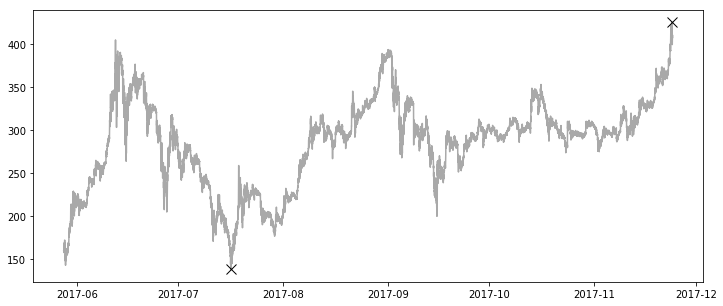

In [5]:
vbt.graphics.plot_line(rate_sr)

# number of positions

In [6]:
fees = 0.0025

In [7]:
# Func
def random_eqdfunc(n):
    # Signals
    v = vbt.signals.random_vector(rate_sr, n)
    idx = np.flatnonzero(v)
    entries = vbt.vector.from_idx(len(rate_sr.index), idx[0::2])
    exits = vbt.vector.from_idx(len(rate_sr.index), idx[1::2])
    # Positions
    pos_sr = vbt.positions.from_vectors(rate_sr, entries, exits)
    if len(pos_sr.index) == 0:
        return pd.Series([])
    # Returns
    posret_sr = vbt.returns.from_positions(rate_sr, pos_sr, fees)
    # Base diffs
    eqd_sr = vbt.equity.base_diffs(rate_sr, posret_sr)
    return eqd_sr

# Params
param_range = list(range(2, 1000, 2)) * 10

In [8]:
random_eqdmap = grids.seriesmap.from_func(random_eqdfunc, param_range)

cores: 4
processes: 3
starmap: False
calcs: 4990 (~29.68s) ..
done. 14.87s


In [9]:
random_nummap = grids.nummap.from_seriesmap(random_eqdmap, vbt.performance.profit)

cores: 4
processes: 3
starmap: False
calcs: 4990 (~1.31s) ..
done. 2.75s
min 6: -174.894155602
max 216: 548.949705024


In [10]:
random_nummap_desc = random_nummap.groupby(random_nummap.index).describe()

     count      mean        std        min        25%       50%        75%  \
50%  499.0 -0.690927  43.431664 -74.223967 -33.896644 -9.973215  24.865561   

            max  
50%  147.958809  


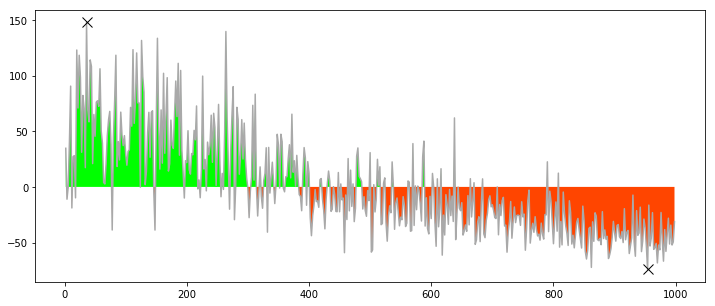

In [11]:
vbt.graphics.plot_line(random_nummap_desc['50%'], 0)

# MA crossover over slices

In [12]:
# Init
ma_func = lambda window: vbt.indicators.EMA(rate_sr, window)
min_ma, max_ma, step = 1, 1000, 10
fees = 0.0025

# Slices
slices = grids.params.slices(rate_sr, 5)

# Cache moving averages
param_range = grids.params.range_params(min_ma, max_ma, step)
mamap = dict(grids.seriesmap.from_func(ma_func, param_range))

cores: 4
processes: 3
starmap: False
calcs: 101 (~0.26s) ..
done. 0.75s


In [15]:
# Func
def ma_eqdfunc(slice_idx, fast_ma, slow_ma):
    # Precalculation
    sliced_rate_sr = rate_sr.iloc[slices[slice_idx]]
    fast_ma_sr = mamap[fast_ma].iloc[slices[slice_idx]]
    slow_ma_sr = mamap[slow_ma].iloc[slices[slice_idx]]
    # Signals
    entries = vbt.vector.first(vbt.signals.DMAC_evector(fast_ma_sr, slow_ma_sr))
    exits = vbt.vector.first(vbt.signals.DMAC_xvector(fast_ma_sr, slow_ma_sr))
    # Positions
    pos_sr = vbt.positions.from_vectors(sliced_rate_sr, entries, exits)
    if len(pos_sr.index) == 0:
        return pd.Series([])
    # Returns
    posret_sr = vbt.returns.from_positions(sliced_rate_sr, pos_sr, fees)
    # Base diffs
    eqd_sr = vbt.equity.base_diffs(rate_sr, posret_sr)
    return eqd_sr

# Params
param_space = grids.params.combine_rep_params(min_ma, max_ma, step, 2)
# Combine with slice index
param_space = grids.params.multiply(list(range(len(slices))), param_space)

In [16]:
ma_eqdmap = grids.seriesmap.from_func(ma_eqdfunc, param_space)

cores: 4
processes: 3
starmap: True
calcs: 25755 (~44.30s) ..
done. 68.55s


In [17]:
ma_nummap = grids.nummap.from_seriesmap(ma_eqdmap, vbt.performance.expectancy)

cores: 4
processes: 3
starmap: False
calcs: 25755 (~1.07s) ..
done. 15.26s
min (3, 791, 891): -9.10977353805
max (1, 301, 991): 45.5651964533


In [18]:
ma_nummap_desc = ma_nummap.groupby(list(zip(*ma_nummap.index))[1:]).describe()

In [19]:
ma_matrix_df = grids.matrix.from_nummap(ma_nummap_desc['std'], symmetric=True).fillna(0)

done. 1.54s


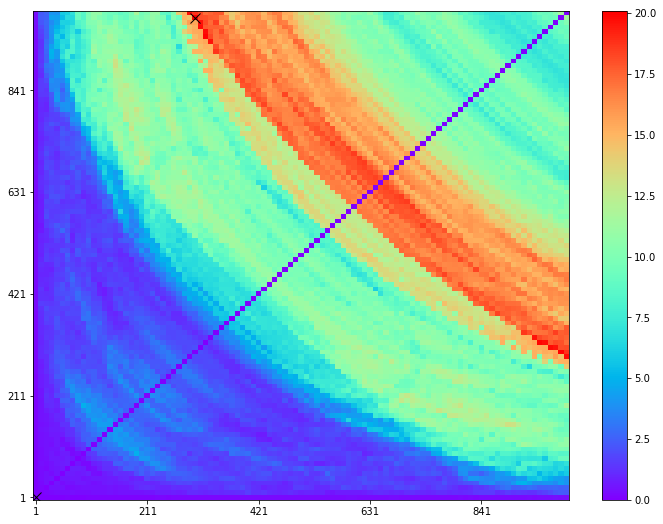

In [20]:
cmap = plt.cm.rainbow
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
grids.matrix.plot(ma_matrix_df, cmap, norm)
matplotlib.rcParams['figure.figsize'] = (12, 5)